In [1]:
import sklearn.datasets as datasets
import numpy as np

In [2]:
mnist = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, data_home="data")

In [3]:
#datasets.fetch_openml?

In [4]:
X, Y = mnist
Y = np.array([int(x) for x in Y], np.int)
X /= 255
X = np.ascontiguousarray(X)

In [5]:
X.shape

(70000, 784)

In [6]:
Y[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [7]:
import numpy as np
import matplotlib.pyplot as plt

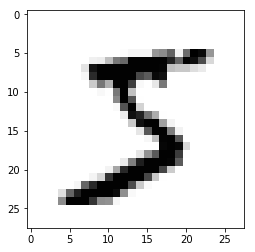

In [8]:
D = X[0].reshape((28,28))
plt.imshow(D, cmap=plt.cm.Greys)

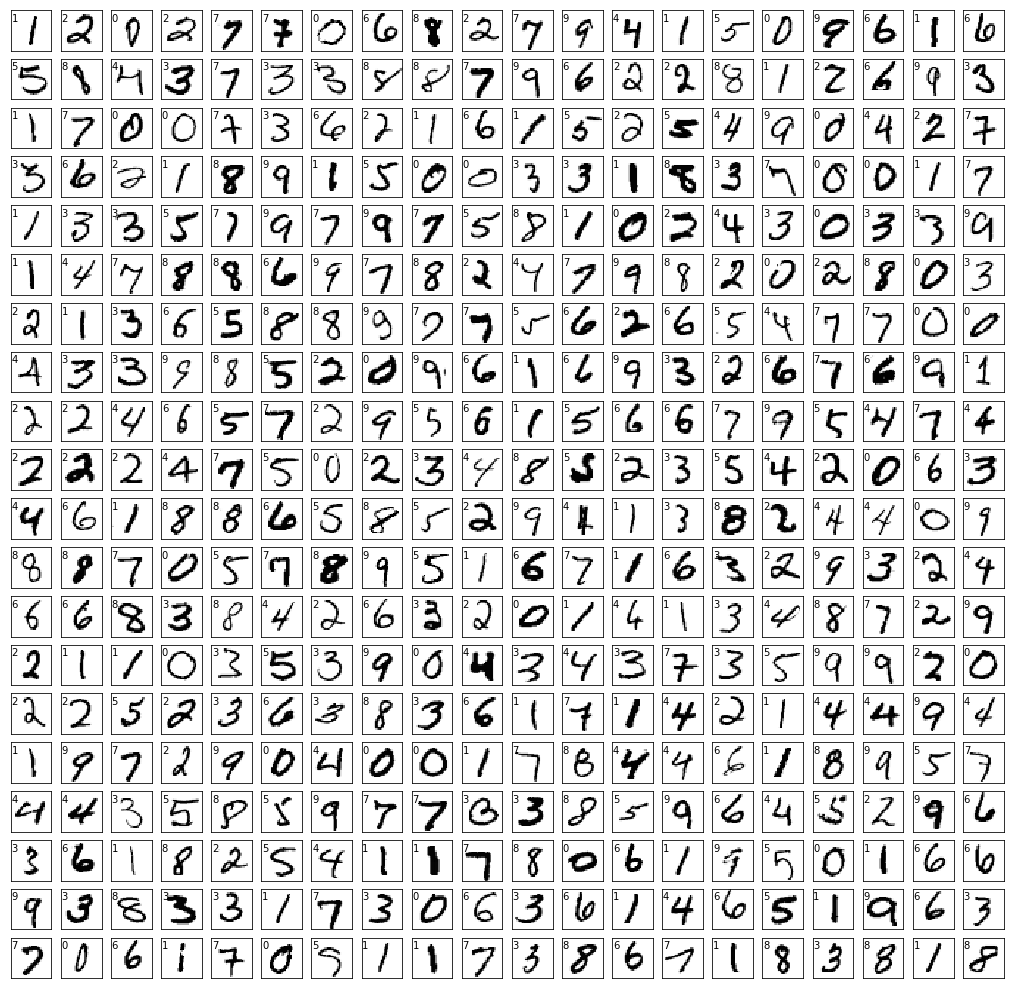

In [9]:
# A = np.array((140,140), 'd')
plt.figure(figsize=(25,25))
for i in range(20):
    x = 28*i
    for j in range(20):
        y = 28*j
        p = np.random.randint(0,70000)
        B = X[p].reshape((28,28))
        d = Y[p]
        plt.subplot(28,28,28*i+j+1)
        plt.imshow(B, cmap=plt.cm.Greys)
        plt.xticks([],[])
        plt.yticks([],[])
        plt.text(0,7, str(d))
#         for k in range(28):
#             for l in range(28):
#                 print(x+k,y+l)
#                 A[x+k,y+l] = B[k,l]

In [10]:
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.risk as risk
import mlgrad.gd as gd

from mlgrad import erm_fg, erm_irgd, fg, weights, averager_it, erisk2, sg, erm_sg

from pprint import pprint

# from axon import loads, dumps
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [11]:
def sigma_neuron_layer2(n_input, n_output):
    layer = model.GeneralModelLayer(n_input)
    outfunc = func.Sigmoidal()
    for i in range(n_output):
        mod = model.SigmaNeuronModel(outfunc, n_input)
        layer.models.append(mod)
    layer.n_input = n_input
    layer.n_output = n_output
    layer.n_param = sum(mod.n_param for mod in layer.models)
    return layer

def linear_neuron_layer2(n_input, n_output):
    layer = model.GeneralModelLayer(n_input)
    for i in range(n_output):
        mod = model.LinearModel(n_input)
        layer.models.append(mod)
    layer.n_input = n_input
    layer.n_output = n_output
    layer.n_param = sum(mod.n_param for mod in layer.models)
    return layer

In [12]:
def sigma_neuron_layer(n_input, n):
    layer = model.SigmaNeuronModelLayer(func.Sigmoidal(), n_input, n)
    return layer

def linear_neuron_layer(n_input, n):
    layer = model.SigmaNeuronModelLayer(None, n_input, n)
    return layer

In [13]:
def binarize(Y, n):
    rows = []
    for y in Y:
        row = np.full(n, -1, 'd')
        row[y] = 1
        #row = 2*row-1
        #row[y] *= 10
        
        rows.append(row)
    return np.array(rows)

Ys = binarize(Y, 10)
print(Ys.shape, X.shape)

(70000, 10) (70000, 784)


In [14]:
n_input = 784
n_hidden = 100
layer1 = sigma_neuron_layer2(n_input, n_hidden)
layer2 = linear_neuron_layer2(n_hidden, 10)

ffnn = model.FFNetworkModel()
ffnn.add(layer1)
ffnn.add(layer2)

ffnn.allocate()

In [28]:
ffnn.param[:] = np.random.random(size=ffnn.n_param)

In [87]:
n_input = 784
n_hidden = 100
layer1 = sigma_neuron_layer2(n_input, n_hidden)
layer2 = linear_neuron_layer2(n_hidden, 10)

ffnn2 = model.FFNetworkModel()
ffnn2.add(layer1)
ffnn2.add(layer2)
del layer1, layer2

ffnn2.allocate()

In [88]:
ffnn2.param[:] = np.random.random(size=ffnn2.n_param)

In [145]:
loss_func = loss.ErrorMultLoss(func.Square())
# batch = risk.make_batch(len(X), 500)
er = erisk2(X, Ys, ffnn, loss_func)
_fg = erm_fg(er, h=0.001, tol=1.0e-6, n_iter=70)
# h_rate = gd.get_learn_rate("pow", [0.5])
# _fg.h_rate = h_rate
print(_fg.K)

70


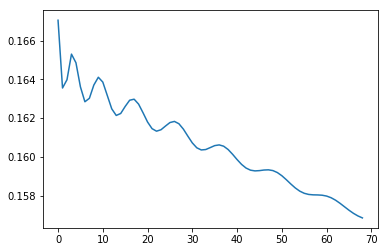

In [146]:
plt.plot(_fg.lvals)
plt.show()

In [147]:
sum([np.argmax(ffnn(x)) == y  for x,y in zip(X,Y)])/len(Y)

0.9720857142857143

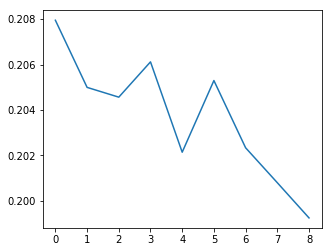

In [148]:
q=0.03
er_wm = erisk2(X, Ys, ffnn2, loss_func)
fg_wm = fg(er_wm, h=0.001, tol=1.0e-6, n_iter=30)
alpha = 1.0-q
avg_wm = averager_it(func.QuantileFunc(alpha, func.Sqrt(0.001)))
wg_wm = weights.WMWeights(avg_wm, er_wm)
irgd_wm = erm_irgd(fg_wm, wg_wm, n_iter=11)

plt.figure(figsize=(5,4))
plt.plot(irgd_wm.lvals)
plt.show()

In [149]:
sum([np.argmax(ffnn2(x)) == y  for x,y in zip(X,Y)])/len(Y)

0.9583142857142857